In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=True, continuous=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True)

INFO:profiler.utility:[0.005772113800048828] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'None', 'none', 'unknown', '?', 'NaN', 'nan'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred opera

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.11158299446105957] Load Embedding start

INFO:profiler.utility:[0.14626789093017578] Load Embedding execution time: 0.03468489646911621



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.1528792381286621] Create Training Data start

INFO:profiler.transformer:needs multiplier = 214 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 214, and the bound is 0.00006293
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 51.27it/s]
INFO:profiler.transformer:Number of training samples: 227772
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0299
INFO:profiler.utility:[7.741415977478027] Create Training Data execution time: 7.588536739349365



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[7.748385190963745] Learn Structure start

INFO:profiler.learner:use threshold 0.0302
INFO:profiler.utility:[7.936799049377441] Learn Structure execution time: 0.1884138584136963



* score: 
    * * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[7.9438841342926025] Get Dependencies start

INFO:profiler.utility:[8.013014078140259] Get Dependencies execution time: 0.06912994384765625



City -> HospitalName (0.04194444309988565)
City,HospitalName -> Address1 (0.03739420738053769)
City,HospitalName,Address1 -> ProviderNumber (0.040307285930752494)
City,HospitalName,Address1,ProviderNumber -> CountyName (0.039641112729627254)
City,HospitalName,Address1,ProviderNumber,CountyName -> PhoneNumber (0.03382141104860194)
City,ProviderNumber,CountyName,PhoneNumber -> HospitalOwner (0.05680458947156139)
City,CountyName,PhoneNumber -> EmergencyService (0.14318489503340642)
MeasureCode -> Condition (0.11936906269271563)
MeasureCode,Condition -> Stateavg (0.026891225888313757)


## 5. Visualization

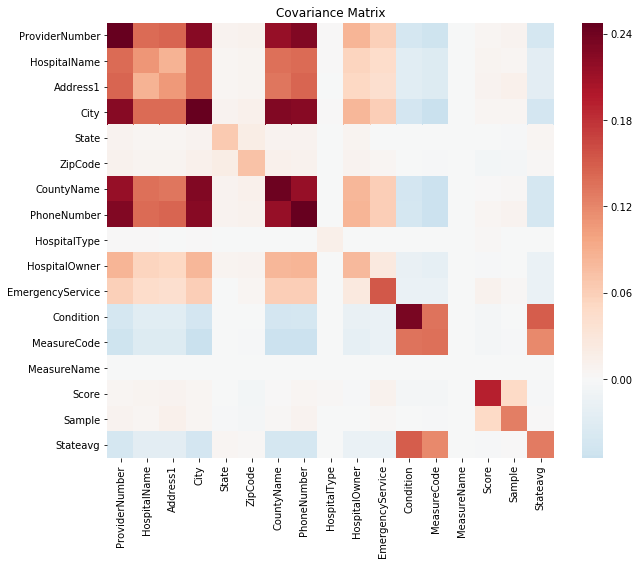

In [13]:
pf.session.visualize_covariance()

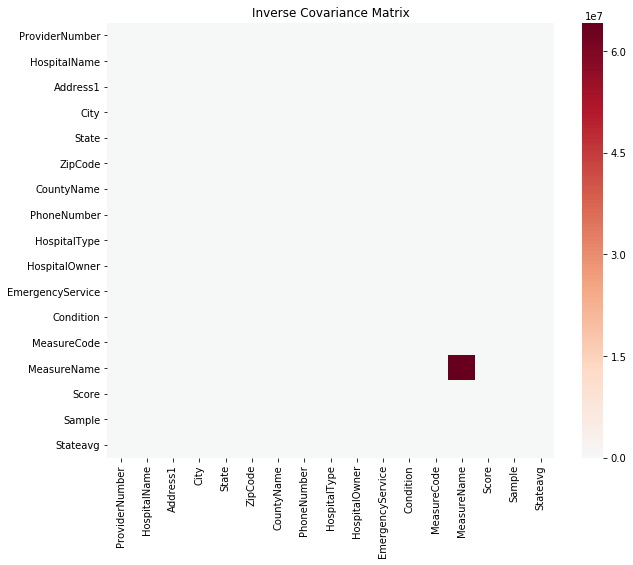

In [10]:
pf.session.visualize_inverse_covariance()

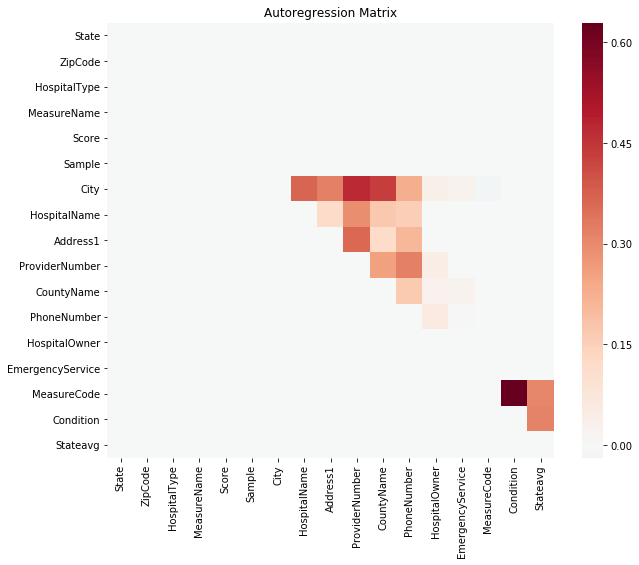

In [11]:
pf.session.visualize_autoregression()

In [12]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.005772,start: Load Data,0.000000
1,0.069980,end: Load Data,0.064208
2,0.111583,start: Load Embedding,0.000000
3,0.146268,end: Load Embedding,0.034685
4,0.152879,start: Create Training Data,0.000000
5,7.741416,end: Create Training Data,7.588537
6,7.748385,start: Learn Structure,0.000000
7,7.936799,end: Learn Structure,0.188414
8,7.943884,start: Get Dependencies,0.000000
9,8.013014,end: Get Dependencies,0.069130
